In [1]:
import pandas as pd
import seaborn as sns
import os
import random
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import warnings
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from adjustText import adjust_text
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

In [2]:
# Function to check the order and calculate the violation
def check_order_and_calculate_violation(order, ratings_matrix):
    num_violations = 0
    violation_diff = 0

    for i in range(len(order)):
        for j in range(i+1, len(order)):
            for k in range(j+1, len(order)):
                # Check if the order violates the rule: Order[i]Order[j] > Order[i]Order[k]
                if ratings_matrix.at[order[i], order[j]] <= ratings_matrix.at[order[i], order[k]]:
                    num_violations += 1
                    violation_diff += abs(ratings_matrix.at[order[i], order[j]] - ratings_matrix.at[order[i], order[k]])

    return num_violations, violation_diff

In [3]:
dir_cat = '/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/8. Similarity in PA task/data/processed_12-15-data/catMeow_rating.csv' 

catsound_names = ['1_300ms', '2_300ms', '5_300ms','8_300ms','11_300ms','17_300ms','18_300ms','24_300ms','25_300ms','26_300ms']
new_catsound_names =  ["Cat1"] + ["Cat" + str(i+2) for i in range(1, 9)]

# Load the CSV file
df = pd.read_csv(dir_cat)

# Mapping from old cat sound names to new names
old_to_new_cat_names = dict(zip(['1_300ms.wav', '2_300ms.wav', '5_300ms.wav', '8_300ms.wav', '11_300ms.wav', 
                                 '17_300ms.wav', '18_300ms.wav', '24_300ms.wav', '25_300ms.wav', '26_300ms.wav'],
                                ["Cat1"] + ["Cat" + str(i+1) for i in range(1, 10)]))

print(old_to_new_cat_names)
# Function to rename cat sound names
def rename_cat_sound(sound_name_with_ext):
    return old_to_new_cat_names.get(sound_name_with_ext, sound_name_with_ext)

# Rename sounds in 'Spreadsheet: A' and 'Spreadsheet: B'
df['Spreadsheet: A'] = df['Spreadsheet: A'].apply(rename_cat_sound)
df['Spreadsheet: B'] = df['Spreadsheet: B'].apply(rename_cat_sound)

# Flip the ratings
df['Flipped Response'] = 6 - df['Response']
#print(df)

# Create a dataframe to hold the average rating for each combination
cat_sound_order = ["Cat1"] + ["Cat" + str(i+1) for i in range(1, 10)]
ratings_matrix = pd.DataFrame(-np.ones((len(cat_sound_order), len(cat_sound_order))), 
                              index=cat_sound_order, columns=cat_sound_order)

# Populate the ratings matrix with average ratings
for i, sound_a in enumerate(cat_sound_order):
    for j, sound_b in enumerate(cat_sound_order):
        if i != j:
            # Get the average rating for this combination
            mask = (
                ((df['Spreadsheet: A'] == sound_a) & (df['Spreadsheet: B'] == sound_b)) | 
                ((df['Spreadsheet: A'] == sound_b) & (df['Spreadsheet: B'] == sound_a))
            )
            ratings = df.loc[mask, 'Flipped Response']
            avg_rating = ratings.mean() if not ratings.empty else -1
            ratings_matrix.at[sound_a, sound_b] = avg_rating
            ratings_matrix.at[sound_b, sound_a] = avg_rating

{'1_300ms.wav': 'Cat1', '2_300ms.wav': 'Cat2', '5_300ms.wav': 'Cat3', '8_300ms.wav': 'Cat4', '11_300ms.wav': 'Cat5', '17_300ms.wav': 'Cat6', '18_300ms.wav': 'Cat7', '24_300ms.wav': 'Cat8', '25_300ms.wav': 'Cat9', '26_300ms.wav': 'Cat10'}


In [4]:
# Function to find the next best fit
def find_next_best_fit(current_element, remaining_elements, ratings_matrix):
    best_fit = None
    highest_similarity = -1  # Initialize with lowest possible similarity

    for element in remaining_elements:
        similarity = ratings_matrix.at[current_element, element]
        if similarity > highest_similarity:
            highest_similarity = similarity
            best_fit = element

    return best_fit

# Find the most similar pair of cat sounds
most_similar_pair = None
highest_similarity = -1  # Initialize with lowest possible similarity
for i, sound_a in enumerate(cat_sound_order):
    for j, sound_b in enumerate(cat_sound_order[i+1:], i+1):
        similarity = ratings_matrix.at[sound_a, sound_b]
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_pair = (sound_a, sound_b)
            
# Start with the most similar pair
start_order = [most_similar_pair[0], most_similar_pair[1]]

# Iteratively find the next best fit
remaining_elements = set(cat_sound_order) - set(start_order)
while remaining_elements:
    last_element = start_order[-1]
    next_element = find_next_best_fit(last_element, remaining_elements, ratings_matrix)
    start_order.append(next_element)
    remaining_elements.remove(next_element)

# Reorder the ratings matrix according to the new order
ratings_matrix_reordered = ratings_matrix.loc[start_order, start_order]

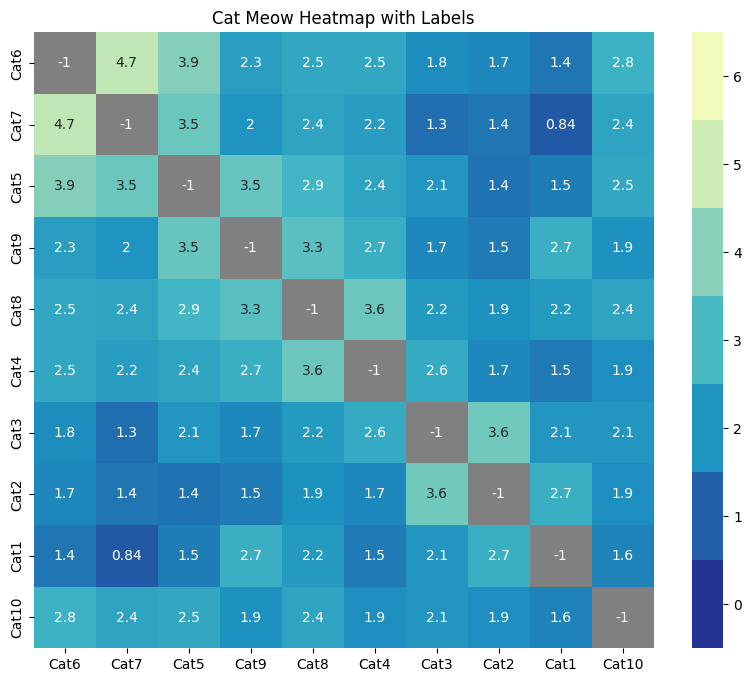

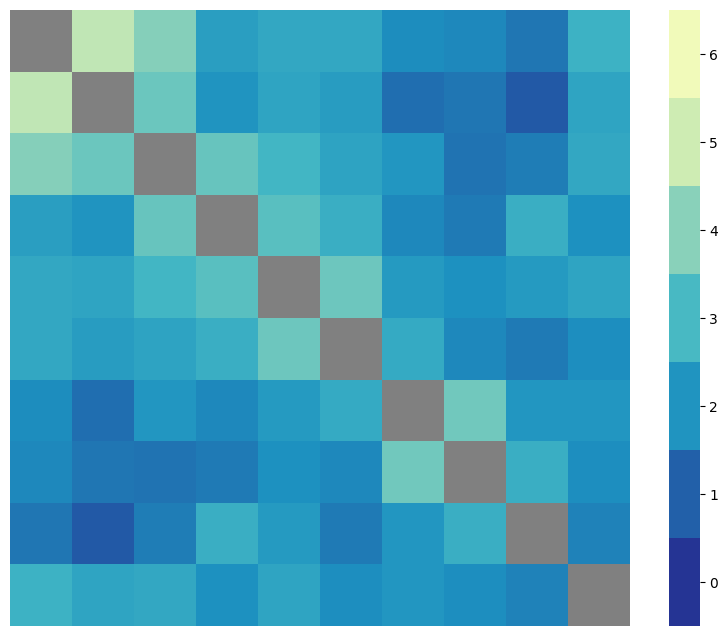

In [5]:

# Define a custom colormap from blue to green
colors_heatmap = plt.cm.YlGnBu(np.linspace(1, 0.1, 256))
colors_heatmap[0] = [0.5, 0.5, 0.5, 1]  # RGB for gray with full opacity
cmap = mcolors.LinearSegmentedColormap.from_list('custom_heatmap', colors_heatmap)

# Plot the heatmap with labels and custom colormap
plt.figure(figsize=(10, 8))
sns.heatmap(ratings_matrix_reordered, annot=True, cmap=cmap, vmin=-1, vmax=6, 
            cbar_kws={'ticks': [0, 1, 2, 3, 4, 5, 6], 'boundaries': np.arange(-0.5, 7, 1)})
plt.title('Cat Meow Heatmap with Labels')
plt.show()

# Plot the heatmap without labels and with the same custom colormap
plt.figure(figsize=(10, 8))
sns.heatmap(ratings_matrix_reordered, cmap=cmap, vmin=-1, vmax=6, 
            cbar_kws={'ticks': [0, 1, 2, 3, 4, 5, 6], 'boundaries': np.arange(-0.5, 7, 1)}, 
            xticklabels='', yticklabels='')

# Save the plot as SVG
save_path = '/Users/willmacbookair/Downloads/Poster plot/catMeow_RSM.svg'
plt.savefig(save_path, format='svg')

plt.show()

### Customized order

In [6]:
# # Find the most similar pair of cat sounds
# most_similar_pair = None
# highest_similarity = -1  # Initialize with lowest possible similarity
# for i, sound_a in enumerate(cat_sound_order):
#     for j, sound_b in enumerate(cat_sound_order[i+1:], i+1):
#         similarity = ratings_matrix.at[sound_a, sound_b]
#         if similarity > highest_similarity:
#             highest_similarity = similarity
#             most_similar_pair = (sound_a, sound_b)

# # Start the order with this most similar pair
# start_order = [most_similar_pair[0], most_similar_pair[1]]

# # Find the best order for the remaining sounds
# remaining_sounds = [sound for sound in cat_sound_order if sound not in start_order]
# best_order = None
# min_violation_diff = float('inf')
# min_num_violations = float('inf')

# for order in itertools.permutations(remaining_sounds):
#     full_order = start_order + list(order)
#     num_violations, violation_diff = check_order_and_calculate_violation(full_order, ratings_matrix)
    
#     # Update the best order based on minimal violation difference and number of violations
#     if num_violations < min_num_violations or (num_violations == min_num_violations and violation_diff < min_violation_diff):
#         best_order = full_order
#         min_violation_diff = violation_diff
#         min_num_violations = num_violations

# # Reorder the ratings matrix according to the best order
# ratings_matrix_reordered = ratings_matrix.loc[best_order, best_order]


In [7]:

# # Define a custom colormap from blue to green
# colors_heatmap = plt.cm.YlGnBu(np.linspace(0.1, 1, 256))
# colors_heatmap[0] = [0.5, 0.5, 0.5, 1]  # RGB for gray with full opacity
# cmap = mcolors.LinearSegmentedColormap.from_list('custom_heatmap', colors_heatmap)

# # Plot the heatmap with labels and custom colormap
# plt.figure(figsize=(10, 8))
# sns.heatmap(ratings_matrix_reordered, annot=True, cmap=cmap, vmin=-1, vmax=6, 
#             cbar_kws={'ticks': [0, 1, 2, 3, 4, 5, 6], 'boundaries': np.arange(-0.5, 7, 1)})
# plt.title('Cat Meow Heatmap with Labels')
# plt.show()

### Ordinary Order

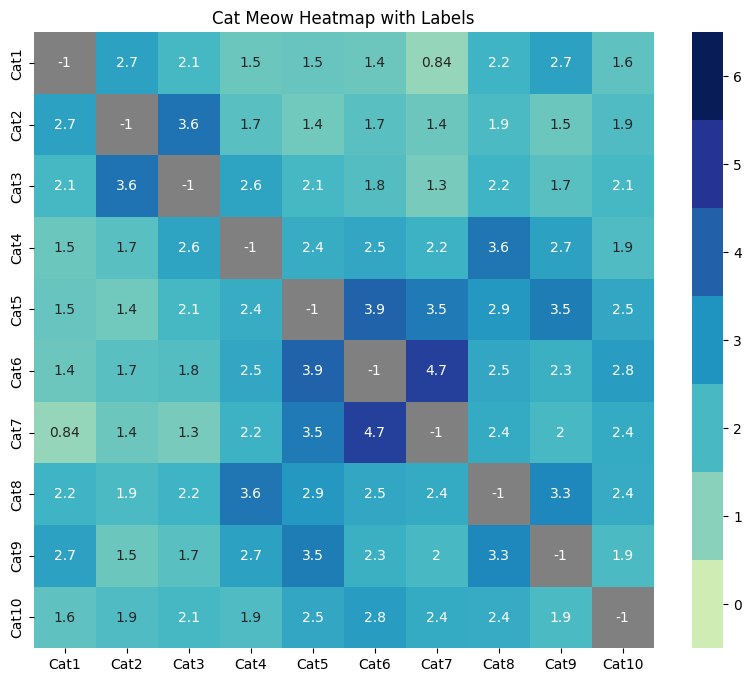

In [8]:
# Populate the matrix with average ratings
for i, sound_a in enumerate(cat_sound_order):
    for j, sound_b in enumerate(cat_sound_order):
        if i != j:
            # Get the average rating for this combination
            mask = (
                ((df['Spreadsheet: A'] == sound_a) & (df['Spreadsheet: B'] == sound_b)) | 
                ((df['Spreadsheet: A'] == sound_b) & (df['Spreadsheet: B'] == sound_a))
            )
            ratings = df.loc[mask, 'Flipped Response']
            avg_rating = ratings.mean() if not ratings.empty else -1
            ratings_matrix.at[sound_a, sound_b] = avg_rating
            ratings_matrix.at[sound_b, sound_a] = avg_rating  # Symmetric entry

# Define a custom colormap from blue to green
colors_heatmap = plt.cm.YlGnBu(np.linspace(0.1, 1, 256))
colors_heatmap[0] = [0.5, 0.5, 0.5, 1]  # RGB for gray with full opacity
cmap = mcolors.LinearSegmentedColormap.from_list('custom_heatmap', colors_heatmap)

# Plot the heatmap with labels and custom colormap
plt.figure(figsize=(10, 8))
sns.heatmap(ratings_matrix, annot=True, cmap=cmap, vmin=-1, vmax=6, 
            cbar_kws={'ticks': [0, 1, 2, 3, 4, 5, 6], 'boundaries': np.arange(-0.5, 7, 1)})
plt.title('Cat Meow Heatmap with Labels')
plt.show()

# # Plot the heatmap without labels and with the same custom colormap
# plt.figure(figsize=(10, 8))
# sns.heatmap(ratings_matrix, cmap=cmap, vmin=-1, vmax=6, 
#             cbar_kws={'ticks': [0, 1, 2, 3, 4, 5, 6], 'boundaries': np.arange(-0.5, 7, 1)}, 
#             xticklabels='', yticklabels='')

# # Save the plot as SVG
# save_path = '/Users/willmacbookair/Downloads/Poster plot/catMeow_RSM.svg'
# plt.savefig(save_path, format='svg')

# plt.show()
